##### Copyright 2020 George Mihaila.

# GPUs in Natural Language Processing


<td>
  <a target="_blank" href="https://github.com/gmihaila/gtc2020_instructor_training/blob/master/content/word_embeddings_sentiment_clustering.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</br>

The main purpose of this tutorial is to target a particular Natural Language Processing (NLP) problem, in this case Sentiment Analysis, and use GPUs for great speedup.

Walkthoughs:

### Dataset used:
* [IMDB moview reviews sentiment dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/): This is a dataset for binary sentiment classification containing a set of **25,000** highly polar movie reviews for training, and **25,000** for testing. For this tutorial we will combine the train and test data for a total of **50,000 movies reviews** text data and their negative/positive labels.


### Content:

 * Train custom word embeddings using a small Neural Network.
 * Use Lime to explain model predictions.
 * Use the embedding model to create review embeddings.
 * Use GPU to perform kmeans clustering on all 50,000 movies reviews.
 * Find the best splitting K using the Elbow method and Silhouette score.
 * Use k=2 on kmeans and plot the sentiments on both predicted clusters and true labels.
 * Observe the overlap between the predcited labels and true labels and asociate labels to clusters. Visualize the clusters.
 * Try to find a third sentiment using k=3. Observe the overlab between predicted labels and true labels. Visualize the clusters.
 * Repeat previous experiments using different k and observe predicitons overlp with true labels. Visualize the clusters.
 * Visualize samples of text that are predicted with various sentiments.

## NLP - Fine-grained Sentiment Analysis

For most cases sentiment classifiers are used in binary classification (just positive or negative sentiment). That is because fine-grained sentiment classification is a significantly more challenging task! 

The typical breakdown of fine-grained sentiment uses five discrete classes, as shown below. As one might imagine, models very easily err on either side of the strong/weak sentiment intensities thanks to the wonderful subtleties of human language.

![alt text](https://miro.medium.com/max/705/1*ug8kyqUlnqEuo3LhHfNypg.png)

Binary class labels may be sufficient for studying large-scale positive/negative sentiment trends in text data such as Tweets, product reviews or customer feedback, but they do have their limitations. 

When performing information extraction with comparative expressions, for example: 
 * “This OnePlus model X is so much better than Samsung model X.” 
  * a fine-grained analysis can provide more precise results to an automated system that prioritizes addressing customer complaints. 

 * “The location was truly disgusting ... but the people there were glorious.” 
  * dual-polarity sentences can confuse binary sentiment classifiers, leading to incorrect class predictions.

[source](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4)



## Notebook Environment Sanity Check

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4 or P100.

[source](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD)

In [1]:
## VERSION CHECK
!nvidia-smi
!nvcc -V
!python -V; pip -V

Mon Mar  2 23:27:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    39W / 300W |   1347MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sentence_transformers import SentenceTransformer
import cudf
from cuml import KMeans
from cuml import PCA as cuPCA
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords 
import nltk
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from lime.lime_text import LimeTextExplainer
import pickle


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

ID_SENTIMENT = {0:'Negative',
                1:'Positive'}

PRETRAINED_MODEL = 'bert-base-nli-stsb-mean-tokens'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Functions

In [3]:
def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return


def predictions_overlap(model_predicitons, true_predicitons, label_decoder):
  """Find overlap between predicted labels that aren't associated with any actual classes
  and actual classes.

  """
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = ["  ".join([str(label_decoder[cluster])+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  # pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    if pos_tag is not None: 
      top_words = nltk.pos_tag(tokens=top_words)
      top_words = [val[0] for val in top_words if val[1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
  return


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

# Dataset Prep

## Read CSV

In [4]:
# get text_features from binary
with open('../data/imdb_reviews_subwords8k_text_features.pickle', 'rb') as handle:
    text_features = pickle.load(handle)
print('Vocabulary size:', text_features.vocab_size)

# read reviews from csv file
review_sentiments_df = pd.read_csv('../data/imdb_reviews_50k.csv')
# get reviews and sentiments
reviews_texts, reviews_sentiments = review_sentiments_df['review'].values, review_sentiments_df['sentiment'].values
# print first 2 examples
review_sentiments_df.head(n=2)

Vocabulary size: 8185


review  \
0  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.   
1  I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.                                                                                               

   sentiment  
0  0          
1  0

## Encode Text

In [5]:
# encode_review
reviews_encodings = [text_features.encode(review) for review in reviews_texts]
# get max length of review
max_review_length = max([len(encoding) for encoding in reviews_encodings])
# global variable
MAX_LEN = max_review_length # 500
# pad all reviews to max length
reviews_encodings = tf.keras.preprocessing.sequence.pad_sequences(sequences=reviews_encodings, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post', value=0.0)

print('reviews_encodings shape:', reviews_encodings.shape)

reviews_encodings shape: (50000, 3944)


# Simple Neural Network

## Config

In [6]:
EMBEDDING_SIZE = 16 #300 #100
BUFFER_SIZE = 1000
BATCH = 500
EPOCHS = 20

## Prep Data

In [7]:
# split train 80% - test 20% 
encodings_train, encodings_test, sentiments_train, sentiments_test = train_test_split(reviews_encodings, reviews_sentiments, train_size=0.8, shuffle=True, random_state=20)
# split train into validation 10%
encodings_train, encodings_valid, sentiments_train, sentiments_valid = train_test_split(encodings_train, sentiments_train, train_size=0.9, shuffle=True, random_state=20)
# shape (number of examples X sequence length)
print('Train shape:     ', encodings_train.shape)
print('Validation shape:', encodings_valid.shape)
print('Test shape:      ', encodings_test.shape)

Train shape:      (36000, 3944)
Validation shape: (4000, 3944)
Test shape:       (10000, 3944)


## Data Generators

In [8]:
# train generator
train_genrator = tf.data.Dataset.from_tensor_slices((encodings_train, sentiments_train))
# batching generator and shuffle
train_batches = train_genrator.batch(BATCH).shuffle(BUFFER_SIZE)
# increase speed by overlaping the preprocessing and model execution of a training step
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# validation generator
valid_genrator = tf.data.Dataset.from_tensor_slices((encodings_valid, sentiments_valid))
# batching generator
valid_batches = valid_genrator.batch(BATCH)
# increase speed by overlaping the preprocessing and model execution of a training step
valid_genrator = valid_genrator.prefetch(tf.data.experimental.AUTOTUNE)

## Modeling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
average (GlobalAveragePoolin (None, 16)                0         
_________________________________________________________________
hidden (Dense)               (None, 16)                272       
_________________________________________________________________
prediction (Dense)           (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________
Train for 72 steps, validate for 8 steps
Epoch 1/20
72/72 [==============================] - 14s 189ms/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.4955
Epoch 2/20
72/72 [==============================] - 20s 273ms/st

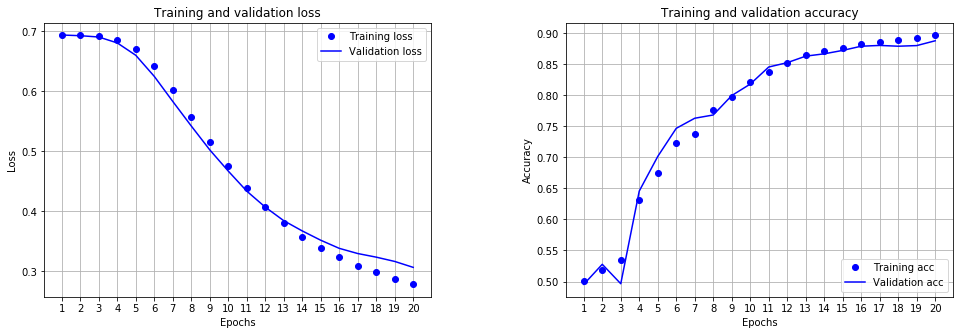

In [9]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(text_features.vocab_size, EMBEDDING_SIZE, name='embedding'))
model.add(tf.keras.layers.GlobalAveragePooling1D(name='average'))
model.add(tf.keras.layers.Dense(16, activation='elu', name='hidden'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='prediction'))
# print overview
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# train and keep track of history
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=valid_batches,
                    verbose=1)
# plot training curves
plt_history(history_dict=history.history)

## Evaluations

In [10]:
# get model predicitons
sentiments_predicitons = model.predict_classes(encodings_test)
# print evaluation report
print(classification_report(y_true=sentiments_test, y_pred=sentiments_predicitons))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4948
           1       0.89      0.87      0.88      5052

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Explain Model

In [11]:
example_index = np.random.randint(0, len(sentiments_test)-1)

review_text = text_features.decode(encodings_test[example_index])
review_sentiment = sentiments_test[example_index]
review_prediction = int(sentiments_predicitons[example_index])

print('Review Sample:\n',review_text)
print('Sentiment:  {}'.format(ID_SENTIMENT[review_sentiment]))
print('Prediciton: {}\n'.format(ID_SENTIMENT[review_prediction]))

# explain model prediciton
def classifier_dn(strings):
  '''Takes as input list of stirngs.
  Outputs numpy array of porbabilities
  '''
  probab = []
  for string in strings:
    encoding = text_features.encode(string)
    encoding = tf.keras.preprocessing.sequence.pad_sequences(sequences=[encoding], 
                                                             maxlen=MAX_LEN, 
                                                             padding='post', 
                                                             truncating='post', 
                                                             dtype='float32')
    preds = model(encoding)[0][0]
    probab.append([(1-preds), preds])
  return np.array(probab)
# create explainer
explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(review_text,  classifier_dn, num_features=MAX_LEN)
# output to cell
exp.show_in_notebook(text=True)

Review Sample:
 My son, an avid skateboarder, sat me down and made me watch this with him. As I love documentaries, it didn't take a whole lot of pressure on his part. The whole amazing story of it all - a bunch of dirt-poor kids drift together and end up creating something revolutionary out of thin air - well, more out of some wood, wheels and lack of waves to surf - it just floored me. It still does. I didn't think I would enjoy it the way I did, nor did I think I would tear up watching Stacey Peralta tear up over the fate of Jay Adams. And just watching Jay Adams himself.....the sheer genius of the kid skating and the shrug of the adult remembering. I watched it again last night for what has to be the 10th time and I still get goosebumps watching him fly down the hill with Jimi Hendrix's "Freedom" playing in the background. And I teared up, again. Not too many movies have the same impact with me after several viewings. Brilliant.
Sentiment:  Positive
Prediciton: Positive



/opt/conda/envs/rapids/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


## Custom Sample

In [12]:
custom_text = "This workshop roks!!"

# create explainer
explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(custom_text,  classifier_dn, num_features=MAX_LEN)
# output to cell
exp.show_in_notebook(text=True)

/opt/conda/envs/rapids/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


# Get Review Embeddings

In [13]:
# create embedding model from previous model
embedding_model = tf.keras.Model(model.inputs, model.get_layer('average').output)
# show embedding model
print(embedding_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
average (GlobalAveragePoolin (None, 16)                0         
Total params: 130,960
Trainable params: 130,960
Non-trainable params: 0
_________________________________________________________________
None


## Get Embeddings

In [14]:
# train generator
reviews_encodings_genrator = tf.data.Dataset.from_tensor_slices(reviews_encodings)
# batching generator and shuffle
reviews_encodings_genrator = reviews_encodings_genrator.batch(BATCH)
# increase speed by overlaping the preprocessing and model execution of a training step
reviews_encodings_genrator = reviews_encodings_genrator.prefetch(tf.data.experimental.AUTOTUNE)
# get review embeddings
reviews_embeddings = embedding_model.predict(reviews_encodings_genrator)

print('Review Embeddings shape: ',reviews_embeddings.shape)

Review Embeddings shape:  (50000, 16)


# Find Best K-means

In [15]:
# maximum number of clusters to use
max_n_cluster = 10

## Elbow Method
* Distortion is defined as the sum of the squared distances between each observation vector and its dominating centroid.
* Find out more about [inertia/distortion](https://scikit-learn.org/stable/modules/clustering.html#k-means)

For n_clusters = 2 Distortion is : 15.231651306152344
For n_clusters = 3 Distortion is : 10.714456558227539
For n_clusters = 4 Distortion is : 7.488612174987793
For n_clusters = 5 Distortion is : 5.857385635375977
For n_clusters = 6 Distortion is : 4.797943592071533
For n_clusters = 7 Distortion is : 4.959665775299072
For n_clusters = 8 Distortion is : 3.9937660694122314
For n_clusters = 9 Distortion is : 3.686741828918457


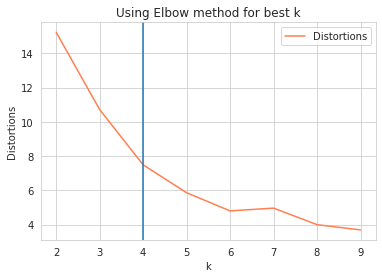

In [16]:
def best_kmeans_elbow(features, n_clusters, verbose=False, show=False):
  features = cudf.DataFrame.from_gpu_matrix(features)
  
  clusters = list(range(2, n_clusters))
  distortions = []

  for n_clusters in clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(features)
    
    distortion = kmean_model.inertia_
    distortions.append(distortion)

    if verbose: print("For n_clusters =", n_clusters, "Distortion is :", distortion)

  kn = KneeLocator(clusters, distortions, curve='convex', direction='decreasing')
  best_k = int(kn.knee)

  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      distortions,
                      color="coral", 
                      label="Distortions")
  plot.set(xlabel='k', ylabel='Distortions')
  plot.set_title('Using Elbow method for best k')
  plot.axvline(x=best_k)
  if show: plt.show()
  fig = plot.get_figure()
#   fig.savefig("elbow_distortions.png")
  return

# run function
best_kmeans_elbow(features=reviews_embeddings, 
                  n_clusters=max_n_cluster, 
                  verbose=True)

## Silhouette Method [time consuming]

* The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

For n_clusters = 2 The average silhouette_score is : 0.5040269
For n_clusters = 3 The average silhouette_score is : 0.47660488
For n_clusters = 4 The average silhouette_score is : 0.46814987
For n_clusters = 5 The average silhouette_score is : 0.4492048
For n_clusters = 6 The average silhouette_score is : 0.43245387
For n_clusters = 7 The average silhouette_score is : 0.4012064
For n_clusters = 8 The average silhouette_score is : 0.40211067
For n_clusters = 9 The average silhouette_score is : 0.42782703


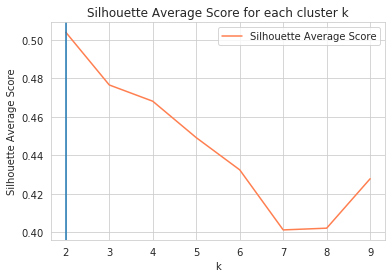

In [17]:
def best_kmeans_silhouette(features, n_clusters):
  features = np.array(features)
  
  clusters = list(range(2, n_clusters))
  silhouettes = []

  for n_clusters in clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(np.array(features))

    cluster_labels = kmean_model.predict(features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouettes.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

  best_k = clusters[silhouettes.index(max(silhouettes))]

  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      silhouettes,
                      color="coral", 
                      label="Silhouette Average Score")
  plot.set(xlabel='k', ylabel='Silhouette Average Score')
  plot.set_title('Silhouette Average Score for each cluster k')
  plot.axvline(x=best_k)
  fig = plot.get_figure()
#   fig.savefig("silhouette_avg.png")
  return

# run fucntion
best_kmeans_silhouette(features=reviews_embeddings, 
                       n_clusters=max_n_cluster)

# Run Best k-means model

In [18]:
# pick best k based on previous experiments
best_k = 2
# build model using specific k
kmean_model = KMeans(n_clusters=best_k)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
best_kmeans_labels = kmean_model.labels_

## PCA Visualize

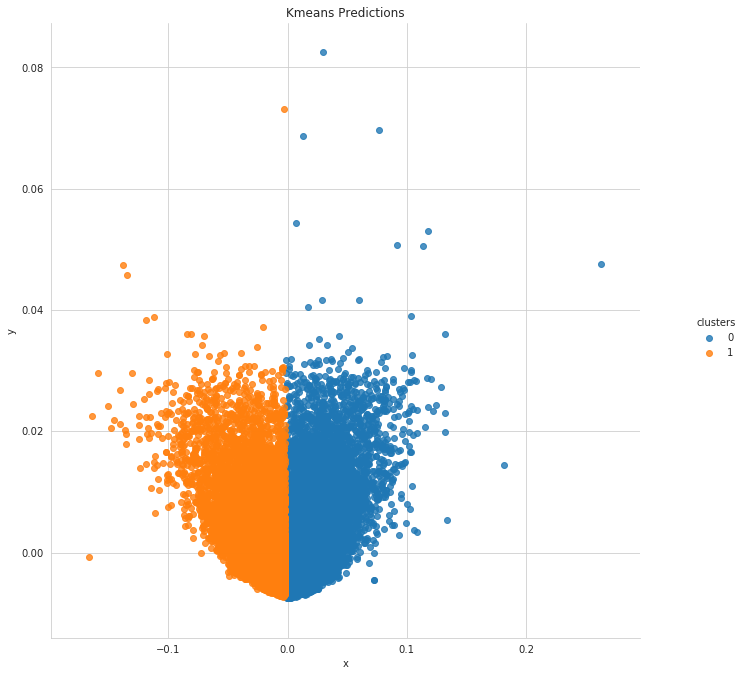

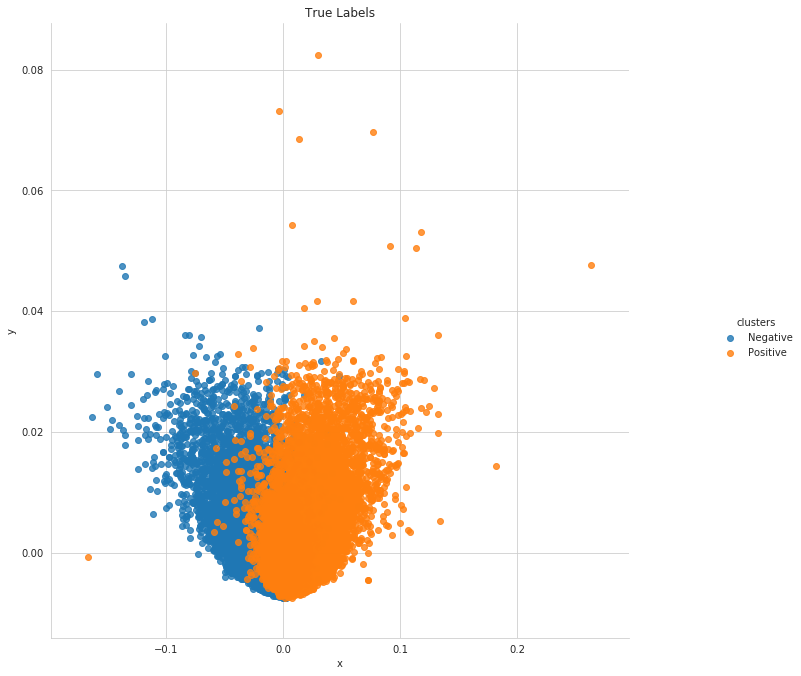



Found labels: [0, 1]



labels                  cluster_match
0  0       Positive:23343  Negative:3792
1  1       Negative:21208  Positive:1657

In [19]:
def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  # move to GPU matrix
  features = cudf.DataFrame.from_gpu_matrix(features)
  pca_cuml = cuPCA(n_components=n_components,
                   random_state=random_state)
  # pca_cuml.fit(features)
  # reduced_features = pca_cuml.transform(gdf_float)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features.values[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features.values[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
#     cluster_plot.savefig("pca_plot.png")
  return reduced_features.values



reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

# K Means Sentiments

## k=3 sentiments

In [20]:
k_sentiments = 3
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [21]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2]



labels                  cluster_match
0  0       Positive:3169  Negative:25   
1  1       Positive:20780  Negative:5684
2  2       Negative:19291  Positive:1051

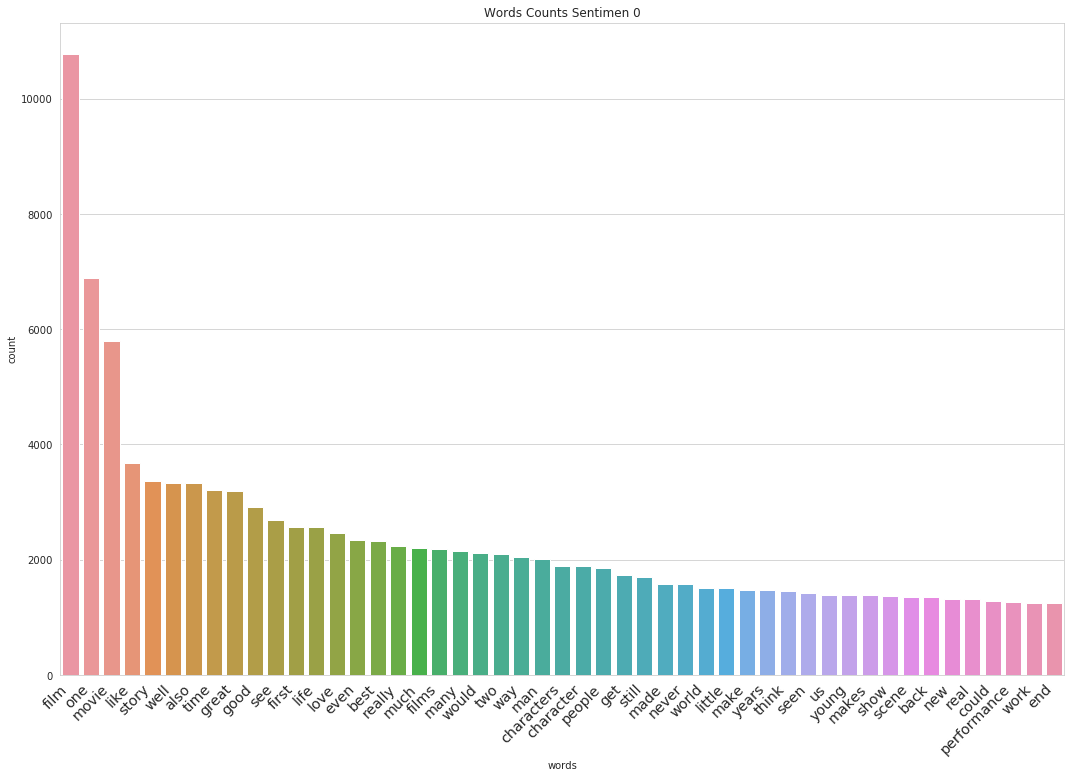

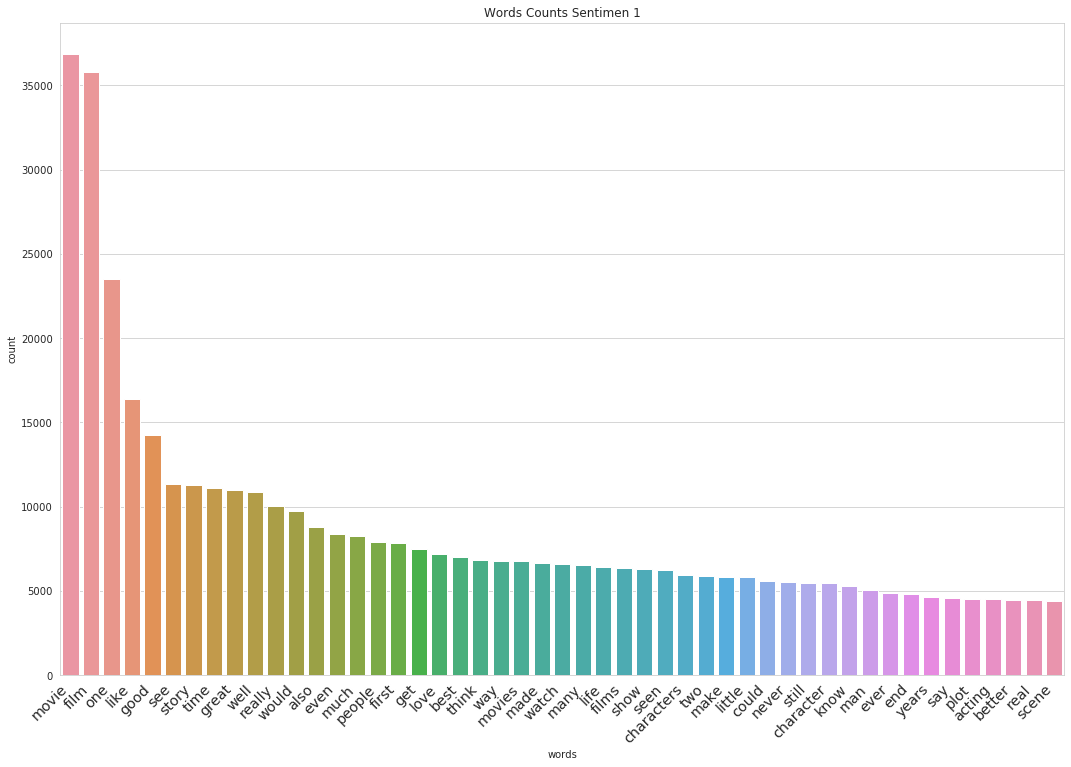

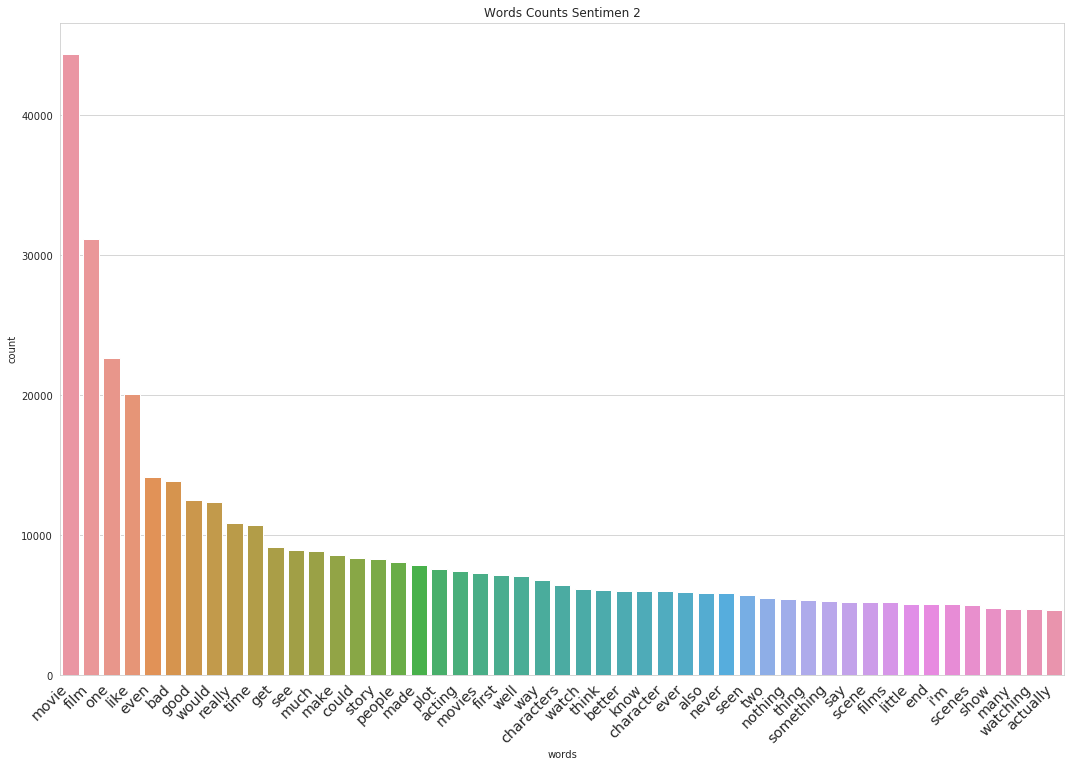

In [22]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

### Visualize

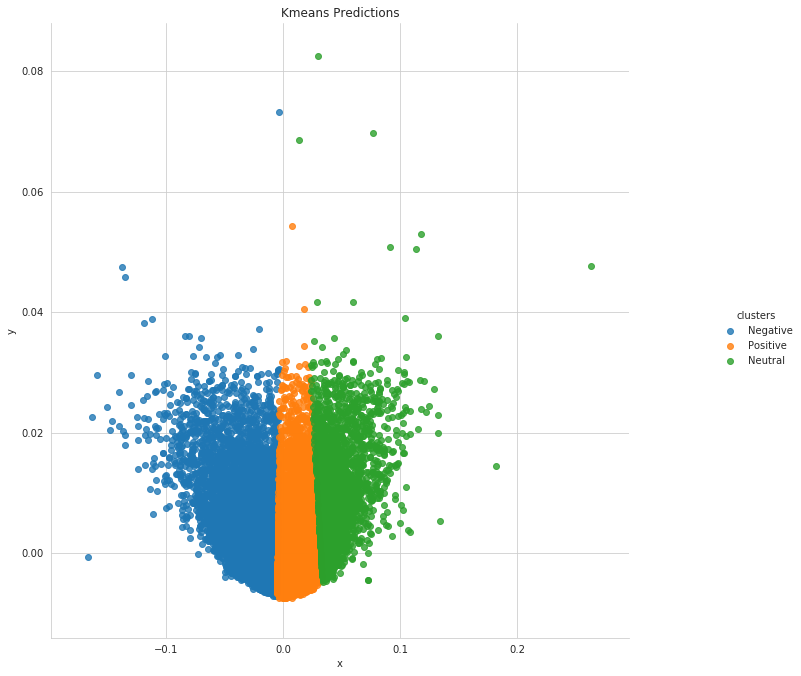

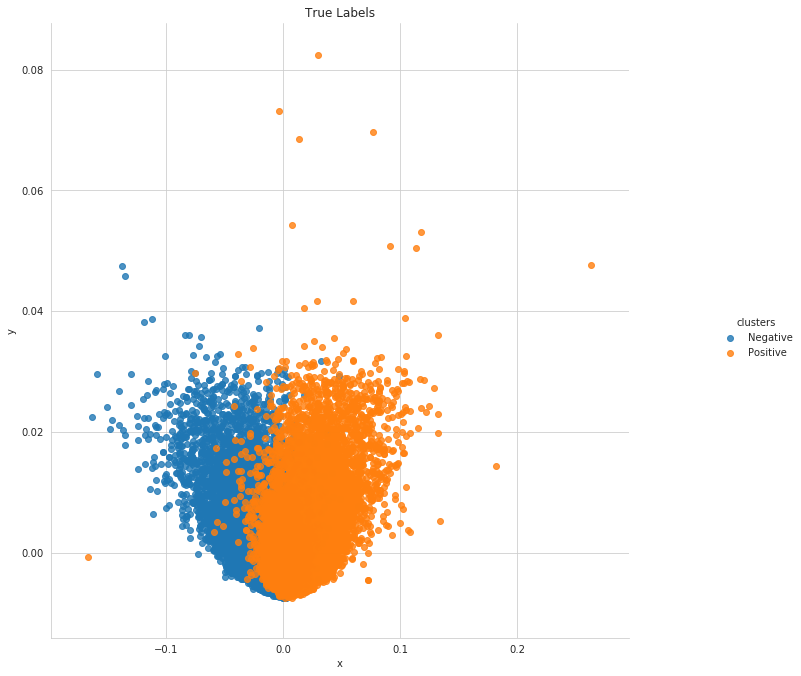

In [23]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [24]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                          trues=reviews_sentiments, 
                          trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                          predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  \
0  In this day and age in which just about every other news story involves discussions of waterboarding, images of Abu Ghraib, or tales of forced detentions at Guantanamo Bay, Gavin Hood's "Rendition" is about as up-to-the-minute and timely a movie as is ever likely to come out of the entertainment mills of mainstream Hollywood. It's not, by any stretch of the imagination, a perfect film, but neither does it merit the caterwauling opprobrium it has received at the hands of critics from all across the ideological and political spectrum.<br /><br />The term "rendition" refers to the ability of the CIA to arrest any individuals it suspects of terrorist dealings, then to whisk them away in secret to a foreign country to interrogate and torture them for an indefinite period of time, all without due process of law. Anwar El-Ibrahimi is an Egyptian man who has been living for twenty years in the United States. He has an American wife, a young son and a new baby on the way. He seems a very unlikely candidate for a terrorist, yet one day, without warning or explanation, Anwar is seized and taken to an undisclosed location where he is subjected to brutal torture until he admits his involvement with a terrorist organization that Anwar claims to know nothing about.<br /><br />On the negative side, "Rendition" falters occasionally in its storytelling abilities, often biting off a little more than it can chew in terms of both plot and character. The ostensible focal point is Douglas Freeman, a rookie CIA agent who is brought in to observe Anwar's "interrogation" at the hands of Egyptian officials. The problem is that, as conceived by writer Kelley Sane and enacted by Jake Gyllenhaal, Freeman seems too much of a naïve "boy scout" to make for a very plausible agent, and he isn't given the screen time he needs to develop fully as a character. We know little about him at the beginning and even less, it seems, at the end. He "goes through the motions," but we learn precious little about the man within. Thus, without a strong center of gravity to hold it all together, the film occasionally feels as if it is coming apart at the seams, with story elements flying off in all directions. A similar problem occurs with Anwar's distraught wife, played by Reese Witherspoon, a woman we never get to know much about apart from what we can see on the surface. Gyllenhaal and Witherspoon have both proved themselves to be fine actors under other circumstances, but here they are hemmed in by a restrictive screenplay that rarely lets them go beyond a single recurring note in their performances.<br /><br />What makes "Rendition" an ultimately powerful film, however, is the extreme seriousness of the subject matter and the way in which two concurrently running plot lines elegantly dovetail into one another in the movie's closing stretches. It may make for a slightly more contrived story than perhaps we might have liked on this subject, but, hey, this is Hollywood after all, and the film has to pay SOME deference to mass audience expectations if it is to get itself green lighted, let alone see the light of day as a completed project.<br /><br />Two of the supporting performances are particularly compelling in the film: Omar Metwally who makes palpable the terror of a man caught in a real life Kafkaesque nightmare from which he cannot awaken, and Yigal Naor who makes a surprisingly complex character out of the chief interrogator/torturer. Meryl Streep, Alan Arkin and Peter Sarsgaard also make their marks in smaller roles. Special mention should also be made of the warm and richly hued cinematography of Dion Beebe.<br /><br />Does the movie oversimplify the issues? Probably. Does it stack the deck in favor of the torture victim and against the evil government forces? Most definitely. (One wonders how the movie would have played if Anwar really WERE a terrorist). Yet, the movie has the guts to tread on controversial ground. It isn't afraid to raise dicey questio

## k=4 sentiments

In [25]:
k_sentiments = 4
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [26]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3]



labels                  cluster_match
0  0       Negative:17729  Positive:4395
1  1       Negative:5893  Positive:83   
2  2       Positive:18577  Negative:1368
3  3       Positive:1945  Negative:10

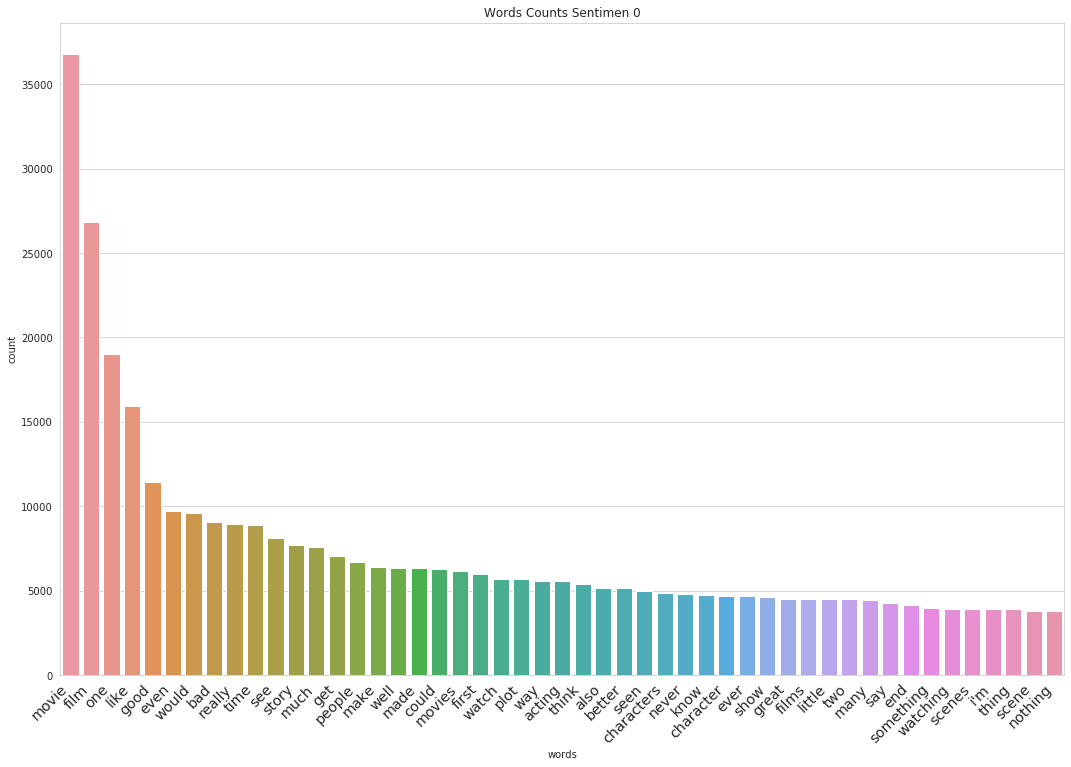

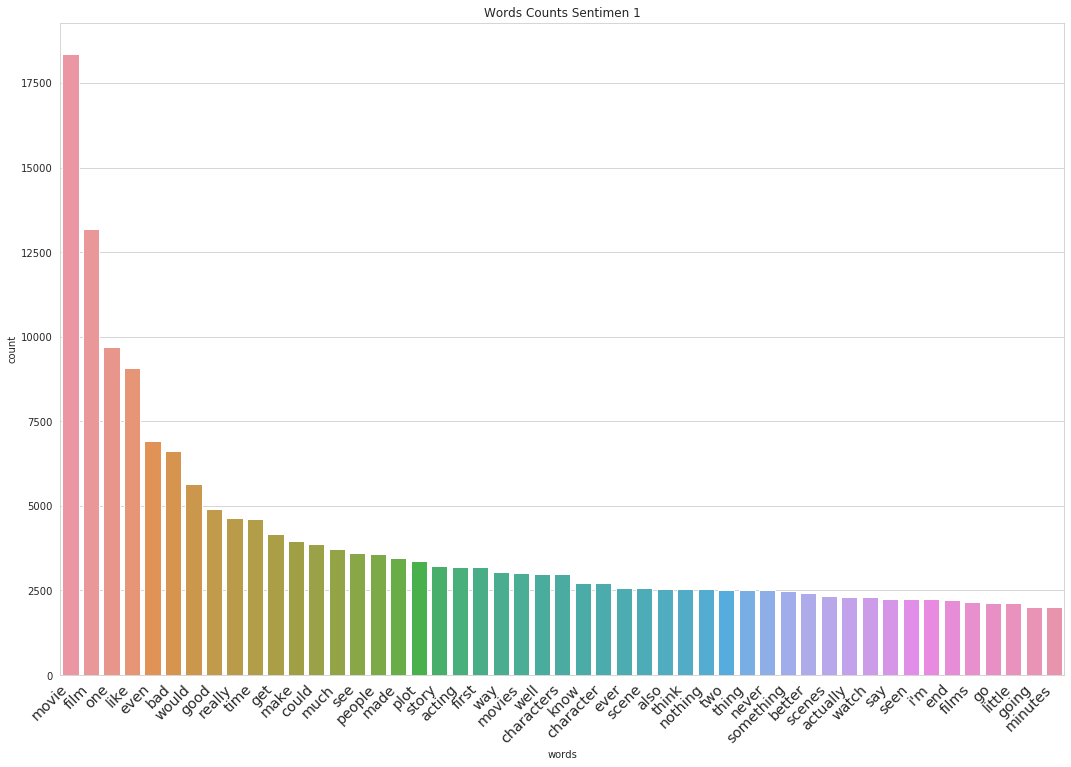

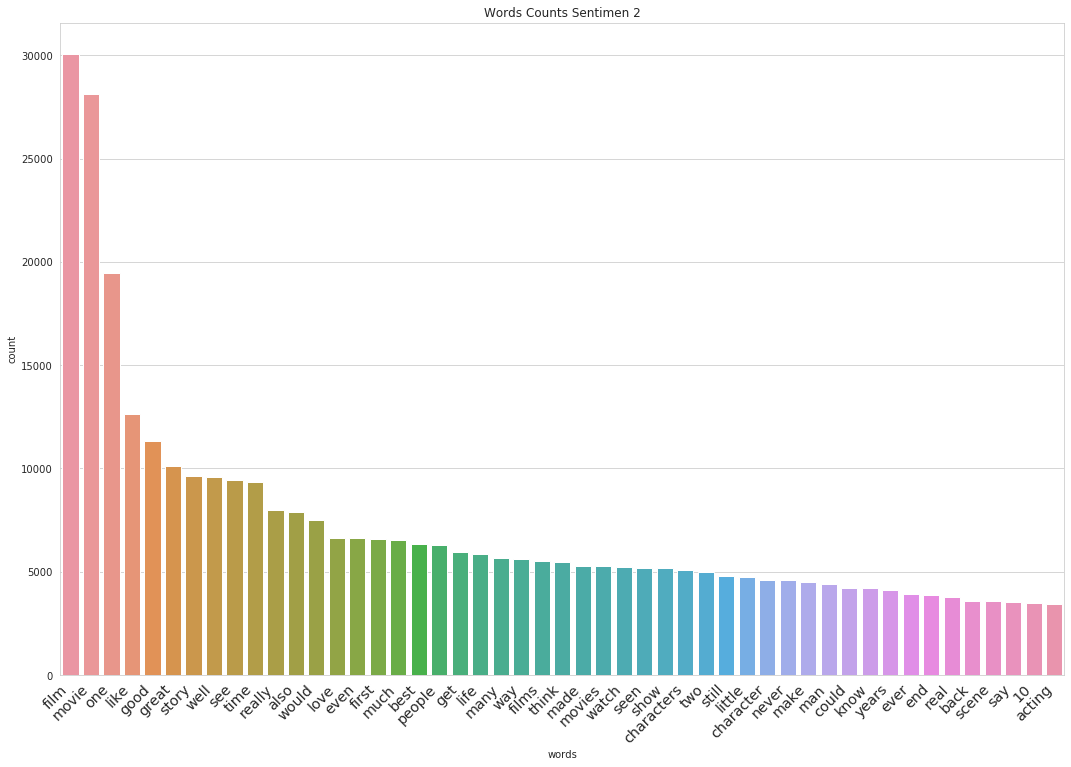

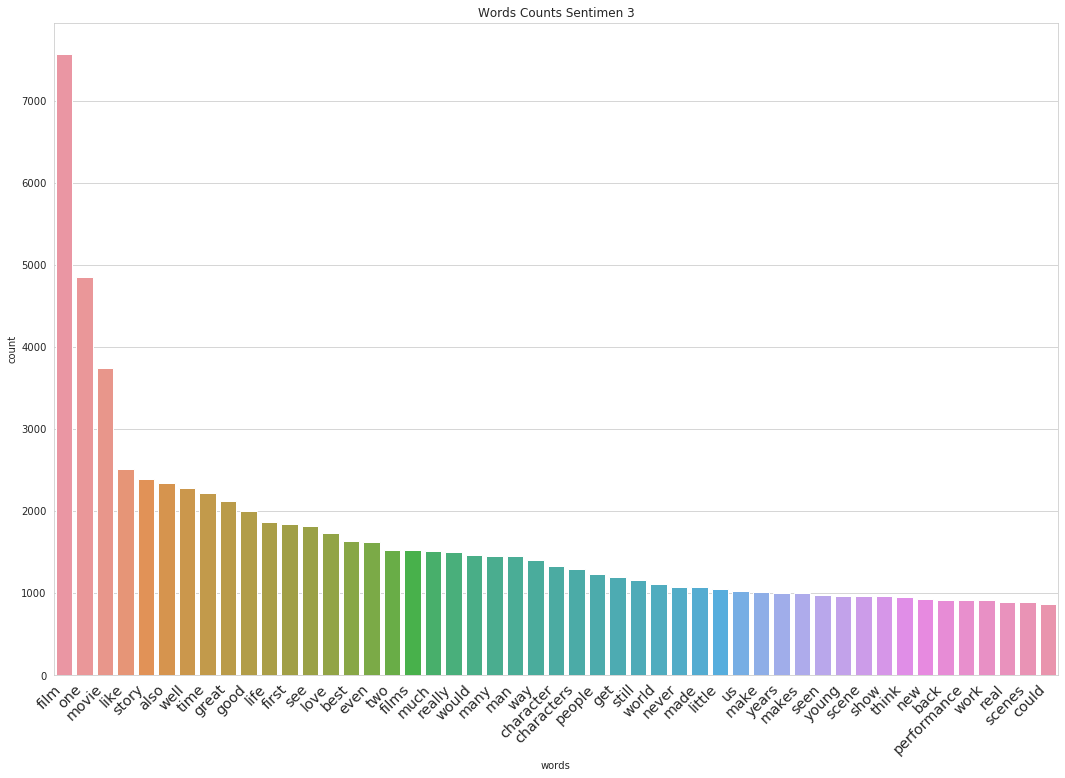

In [27]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

### Visualize

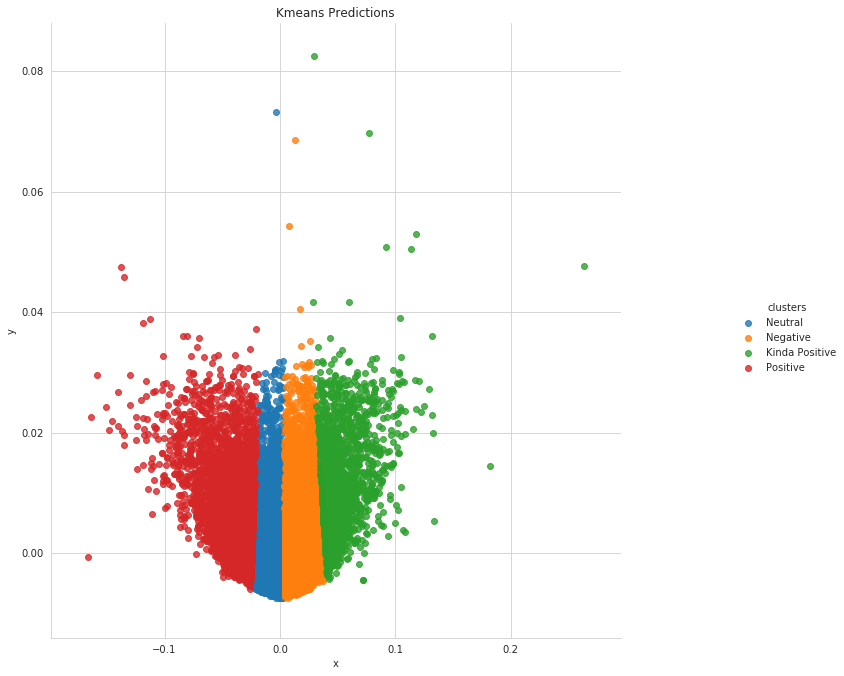

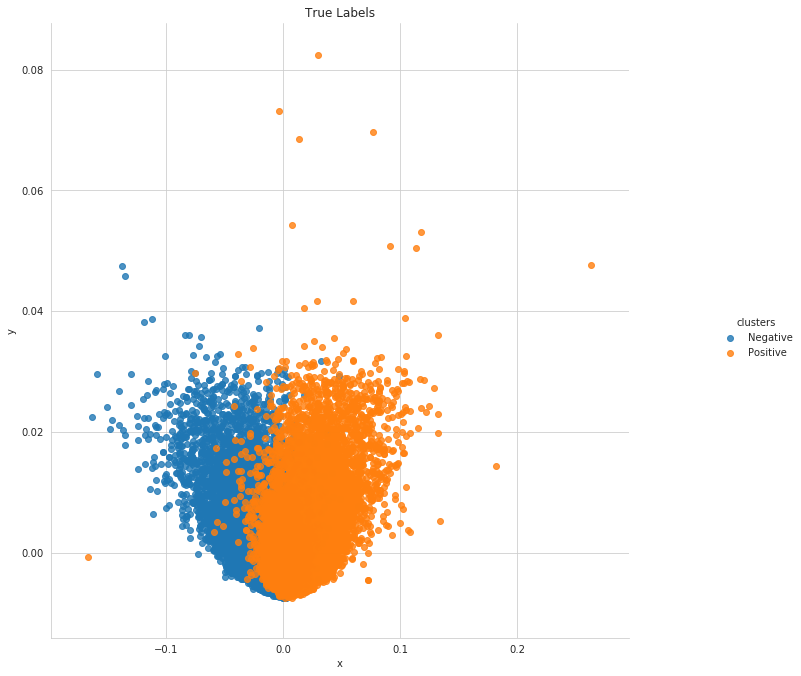

In [28]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [29]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                        trues=reviews_sentiments, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  \
0  Knowing how old a film is, ought to prepare the viewer for a few things, and, with those things in mind, perhaps the movie'll be more tolerable. So it was when I watched Revolt of the Zombies. The heavy reliance on tedious dialogue and corny movements should be expected, as should the primitiveness (or absence) of special effects in those days. A great deal is asked from the imagination of the onlooker - maybe too much, in this case. And the plot isn't easy to follow: Some zombiefied southeast Asian soldiers in WWI performed very admirably. Although skeptical as to why, if true, the explanation should stay out of the wrong hands, so, off goes a group to archaeologically investigate. The key to long-distance hypnosis is learned by a member of the expedition, who uses it to, among other purposes, temporarily dispense with the beau of the gal for whom he has the hots. To prove his love for her, he gives up his hold on everybody, which he shouldn't have done 'cause, once they're all unzombiefied, many want to kill him so that he'll never control them again. Below average, even with precautionary forethought. Recommended for only the extremely patient.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
1  I wanted to love this film so badly...I really did. But it was a horrible disappointment.<br /><br />I read Jennifer Egan's novel in 1996 and was enthralled by the story. In fact it remains one of my favorite books of all time. Mind you, the book had much more depth than this movie, in plot and emotional resonance. It MADE you care about the characters. It painted a complete picture of Phoebe, unlike the utterly poor characterization of the young girl in the film.<br /><br />Though beautiful and showing *some* promise in her burgeoning career, Jordana Brewster was as flat and hollow in this performance as was the script. And Christopher Eccleston (Wolf) was just an awful choice for the role of Wolf, both physically and logistically. What an awkward looking couple. Wolf should have been more of a dark brooding character, and more physically alluring, like he was in the book. What's more, the chemistry between the two actors was painfully forced.<br /><br />Cameron Diaz, however, deserves utmost praise for her performance. She took an impossibly mediocre script and gave her character life, a real spirit. She is simply gorgeous and her careful mannerisms make her very believable as a hippie. It's too bad her talent was squandered on this forgettable film.<br /><br />In the book-to-movie category, this is a dreadful translation, almost as bad as Message in a Bottle with Kevin Costner. But don't get me started on that one...<br /><br />I am not usually so harsh in my critiques but I was so disappointed here, because I really cared about the story and wanted to see it told right. It did not deliver...<br /><br />   
2  as a habit i always like to read through the 'hated it' reviews of any given movie. especially one that i'd want to comment on. and it's not so much a point-counterpoint sorta deal; i just like to see what people say on the flipside.<br /><br />however, i do want to address one thing. many people that hated it called it, to paraphrase, 'beautiful, but shallow,' some even going so far as to say that norm's desire yet inability to help his brother was a mundane plot, at best.<br /><br />i'd like to disagree.<br /><br />as a brother of a sibling who has a similar dysfunction, i can relate. daily, you see them abuse themselves, knowing only that their current path will inevitably lead them to self-dest

# Custom Samples

In [31]:
custom_text = "This workshop roks!!"

encoding = text_features.encode(custom_text)
encoding = tf.keras.preprocessing.sequence.pad_sequences(sequences=[encoding], 
                                                       maxlen=MAX_LEN, 
                                                       dtype='int64', 
                                                       padding='post', 
                                                       truncating='post', 
                                                       value=0)
embedding = embedding_model(encoding)
kmean_label = kmean_model.predict(tf.get_static_value(embedding))[0]

print('Text: ',custom_text)
print('Sentiment: ', kmeans_id_sentiment[kmean_label])

Text:  This workshop roks!!
Sentiment:  Neutral
